In [1]:
using LinearAlgebra
using Plots
using SparseArrays
using Arpack #Eigenvalues of sparse arrays with eigs()
using DifferentialEquations
# using DiffEqFlux
using Optim
using ForwardDiff
using DelimitedFiles
using LineSearches

In [2]:
#Def parameters
n_cutoff = 8
N = 2 * n_cutoff + 1
NHilbert = N^2
n = sparse(Diagonal(LinRange(-n_cutoff, n_cutoff, N))) #Perhaps implement using StaticArrays
# n = sparse(Diagonal(LinRange(n_cutoff, 3*n_cutoff+1, N))) #Perhaps implement using StaticArrays

Id = sparse(I, N, N)
exp_iPhi = spdiagm(-1 => ones(N - 1));

#Def Hamiltonian parameters
E_J_GHz = 10.0 #scale of E_J in units of h*GHz, h-bar = 1, h = 2pi
E_C = 1/100  #Charging energies
E_J = 1.0 #Josephson energies
phi_ext = 0.995pi

prefactor = 4 * E_C
Kinetic = 2pi * E_J_GHz * prefactor * (kron(n^2, Id) .+ kron(Id, n^2))

Potential1 = -2pi * E_J_GHz * kron(1 / 2 * (exp_iPhi .+ exp_iPhi'), Id) # -E_J1 cos(phi1)
Potential2 = -2pi * E_J_GHz * kron(Id, 1 / 2 * (exp_iPhi .+ exp_iPhi')) # -E_J2 cos(phi2)
Pot3Mat = kron(exp_iPhi, exp_iPhi')
Pot3Const = -2pi * E_J_GHz * E_J / 2

function get_Pot3(Φ_ext = phi_ext)
    M = exp(im * Φ_ext) * Pot3Mat
    return Pot3Const * (M + M')
end

function dPot3_dphi(Φ_ext = phi_ext)
    M = exp(im * Φ_ext) * Pot3Mat
    return (im * Pot3Const) .* (M - M')
end

Potential3 =  get_Pot3() #-E_J3 cos(phi1 - phi2 + phi_ext)
Potential12 = E_J * (Potential1 + Potential2)
KinPot12 = Kinetic + Potential12
chargecoupling = kron(n, Id);

In [3]:
function limit_func(param,pmin,pmax)
    (pmax - pmin) * (1/(1 + exp(-param))) + pmin
end

function inv_limit_func(param,pmin,pmax)
    # -log( (pmax - pmin  + 2e-8) / (param - pmin + 1e-8) - 1)
    -log( (pmax - pmin) / (param - pmin) - 1)
end

function alpha(p, t)
    Tₐ = 10#limit_func(p[2],0,15)
    Tₚ = 30 - 2*Tₐ#p[3]
    αmin = limit_func(p[1],0.5,1)
    abs_slope = (1 - αmin)/Tₐ
    if t < Tₐ
        return 1 - abs_slope * t
    elseif t > Tₐ + Tₚ
        return αmin + abs_slope * (t - Tₐ - Tₚ)
    else
        return αmin
    end
end

dalphadp(p, t) = ForwardDiff.gradient(p̃ -> alpha(p̃,t), p)

h_times = LinRange(10,20,50+2)[2:end-1]
dt = h_times[2] - h_times[1]
function pulse(p, t)
    if  t < 10 || t > 20
        return 0
    end
    out = 0
    w_start = exp( - 5/(2*dt^2) * (t - 10)^2)
    w_end = exp( - 5/(2*dt^2) * (t - 20)^2)
    w_sum = w_start + w_end
    for (i, ht) in enumerate(h_times)
        w = exp( - 5/(2*dt^2) * (t - ht)^2)
        out += p[i+1] * w
        w_sum += w
    end
    # envelope(t)*out/w_sum
    out/w_sum
end

dpulsedp(p, t) = ForwardDiff.gradient(p̃ -> pulse(p̃, t), p)

dpulsedp (generic function with 1 method)

In [69]:
randp = 1 .* (rand(50) .- 0.5)
p = cat([inv_limit_func(0.55,0.5,1)],randp,dims=1) ;

In [70]:
Es = eigvals(Matrix(KinPot12 + Potential3))
ψs = eigvecs(Matrix(KinPot12 + Potential3));

M = Pot3Const * exp(im * phi_ext) * Pot3Mat

ψ0 = ψs[:,1:2]

Es = real.(Es) ;
proj = zeros(ComplexF64,NHilbert,2)
Hphimærke = dPot3_dphi(phi_ext)
for i in 2:NHilbert
    if i != 1
        proj[:,1] += ψs[:,i]'*Hphimærke*ψs[:,1]/(Es[1] - Es[i])*ψs[:,i]
    end
    if i != 2
        proj[:,2] += ψs[:,i]'*Hphimærke*ψs[:,2]/(Es[2] - Es[i])*ψs[:,i]
    end
end

fu0 = cat(ψ0,-proj,dims=2)

sizep = length(p)
m = 0.00001/pi

3.183098861837907e-6

In [71]:
function f!(du, u, p, t)
    x = u[:,1:2]
    ψ = u[:,3:4]
    H = KinPot12 + alpha(p,t) .* Potential3 + pulse(p,t) .* chargecoupling

    du[:,1:2] = -im .* (H * x)
    du[:,3:4] = -im .* (H * ψ) - alpha(p,t) .* ((M - M') * x)
end

Uv = chargecoupling
Ua = Potential3#Um + Um'
dUa = M - M'

l1sscale = m

function b!(du, u, p, t)
    x = u[:,1:2]
    ψ = u[:,3:4]
    λ = u[:,5:6]
    ϕ = u[:,7:8]
    ps = u[:,9]
    α = alpha(p,t)
    dαdp = dalphadp(p,t)
    dpdp = dpulsedp(p,t)

    miH = -im .* (KinPot12 + α .* Potential3 + pulse(p,t) .* chargecoupling)

    du[:,1:2] = miH * x
    du[:,3:4] = miH * ψ - α * dUa * x
    du[:,5:6] = miH * λ
    du[:,7:8] = miH * ϕ + α * dUa * λ
    
    du[1:sizep,9] = 2 .* (
    - real(im * tr(λ' * Uv * x)) .* dpdp
    - real(im * tr(λ' * Ua * x)) .* dαdp )
    
    du[end,9] = 2 * real(tr(λ' * dUa * x) * α)
    
    du[sizep+1:2*sizep,9] = 2 .* (
    - real(im * (tr(ϕ' * Uv * x) + tr(ψ' * Uv * λ))) .* dpdp 
    - real(im * (tr(ϕ' * Ua * x) + tr(ψ' * Ua * λ))) .* dαdp 
    # + real(tr(ϕ' * (F .* Ua) * x) + tr(ψ' * (F .* Ua) * λ)) .* ddalphadpdt(p,t) 
    - real(tr(x' * dUa * λ)) .* dαdp )
    # - real(im * tr(x' * (F .* dUa)' * λ)) .* ddalphadpdt(p,t)
end

b! (generic function with 1 method)

In [134]:
forward_prob = ODEProblem(f!, fu0, (0.0, 30.0), p)
sol_f = solve(forward_prob, p=p, save_everystep=false, reltol=1e-8, abstol=1e-8)

# DT = sol_f.u[end][:,1]
# UmT = sol_f.u[end][:,2:N+1] #Ua = Um + Um'
# UvT = sol_f.u[end][:,N+2:2*N+1]
xT = sol_f.u[end][:,1:2]
ψT = sol_f.u[end][:,3:4]

ϕcorrection = cat(
    -xT[:,1]'*proj[:,2]*ψ0[:,2]' -xT[:,1]'*ψ0[:,2]*proj[:,2]',
    -xT[:,2]'*proj[:,1]*ψ0[:,1]' -xT[:,2]'*ψ0[:,1]*proj[:,1]',dims=1
)'
# ϕcorrection = -cat(
#     (ψ0[:,2]*proj[:,2]' + proj[:,2]*ψ0[:,2]')*xT[:,1],
#     (ψ0[:,1]*proj[:,1]' + proj[:,1]*ψ0[:,1]')*xT[:,2],dims=2
# )

λ = 0.5 .* cat(ψ0[:,2]*ψ0[:,2]'*xT[:,1],ψ0[:,1]*ψ0[:,1]'*xT[:,2],dims=2)
ϕ = -0.5 .* ϕcorrection + 0.5 .* cat(-ψ0[:,2]*ψ0[:,2]'*ψT[:,1],-ψ0[:,1]*ψ0[:,1]'*ψT[:,2],dims=2)
# ϕ = zeros(NHilbert,2)

ps = zeros(289,1) #only 2*length(p) are possibly used
bu0 = cat(xT,ψT,λ,ϕ,ps,dims=2);

backward_prob = ODEProblem(b!, bu0, (30.0, 0.0), p)
sol_b = solve(backward_prob, p=p, save_everystep=false, reltol=1e-8, abstol=1e-8)

UT = abs2.(ψ0'*xT)
infidelity = 0.5 * (2 - UT[1,2] - UT[2,1])
# grad_phi = real(sol_b.u[end][sizep,9])

0.9858407997149834

In [ ]:
# solve()

In [73]:
grad_phi = real(sol_b.u[end][end,9]) + real(-xT[:,1]'*proj[:,2]*ψ0[:,2]'*xT[:,1] -xT[:,1]'*ψ0[:,2]*proj[:,2]'*xT[:,1]) - 2*real(tr(sol_b.u[end][:,5:6]'*proj))
grad = real(sol_b.u[end][1:sizep,9])
Dgrad = real(sol_b.u[end][sizep+1:2*sizep,9])
;

In [74]:
function fidel(phi_ext,ps)
    Potential3 = get_Pot3(phi_ext)
    # Es, ψs = eigs(KinPot12 + Potential3, nev=2, which=:SR, tol=0.0, maxiter=10000);
    ψs = eigvecs(Matrix(KinPot12 + Potential3))

    function H!(du, u, p, t)
        du[:] = - im * (KinPot12 + alpha(p,t) .* Potential3 + pulse(p,t) .* chargecoupling) * u
    end

    forward_prob = ODEProblem(H!, ψs[:,1:2], (0.0, 30.0), ps)
    sol = solve(forward_prob, p=ps, save_everystep=false, reltol=1e-10, abstol=1e-10)

    UT = abs2.(ψs[:,1:2]'*sol.u[end])
    return 0.5 * (2 - UT[1,2] - UT[2,1])
end
dp = 7e-4
# dpp = zeros(Float64,size(p))
# dpp[26] = dp

FD_phigrads = []
FD_Dgrads = []
FD_grads = []
# for dp in [1e-2,1e-3,1e-4,1e-5,1e-6,1e-7,1e-8]
for i in 1:51
    dpp = zeros(Float64,size(p))
    dpp[i] = dp
    pp = fidel(0.995pi+dp,p+dpp)
    pm = fidel(0.995pi+dp,p-dpp)
    mp = fidel(0.995pi-dp,p+dpp)
    mm = fidel(0.995pi-dp,p-dpp)
    push!(FD_phigrads,((pp - mp)/(2*dp) + (pm - mm)/(2*dp))/2)
    push!(FD_grads,((pp - pm)/(2*dp) + (mp - mm)/(2*dp))/2)
    push!(FD_Dgrads,(pp - pm - mp + mm)/(4*dp*dp))
    end

In [144]:
tmp_phigrads = []
for dp in [1e-2,1e-3,1e-4,1e-5,1e-6,1e-7,1e-8]
    ptmp = fidel(0.995pi+dp,p)
    mtmp = fidel(0.995pi-dp,p)
    push!(tmp_phigrads,(ptmp-mtmp)/(2dp))
end

In [145]:
tmp_phigrads

7-element Vector{Any}:
 -1.40659615314912
  1.0834128874759874
  1.0613613182669512
  1.0611936702709102
  1.06206946942633
  1.060964691101951
  1.0705260677923434

In [157]:
real(sol_b.u[end][end,9]), 2*real(-xT[:,1]'*proj[:,2]*ψ0[:,2]'*xT[:,1] -xT[:,2]'*proj[:,1]*ψ0[:,1]'*xT[:,2]), - 2*real(tr(sol_b.u[end][:,5:6]'*proj)),grad_phi

(1.116511578792393, 0.18272814995154762, -0.12478339372682763, 0.9935313651741791)

In [131]:
-2*real((sol_b.u[end][:,5:6]'*proj)[1,2] + (sol_b.u[end][:,5:6]'*proj)[2,1])

-0.02675457480066676

In [153]:
2*(
# ψT[:,1]'*ψ0[:,2]*ψ0[:,2]'*xT[:,1]
+xT[:,1]'*proj[:,2]*ψ0[:,2]'*xT[:,1]
# +xT[:,1]'*ψ0[:,2]*proj[:,2]'*xT[:,1]
+xT[:,1]'*ψ0[:,2]*ψ0[:,2]'*ψT[:,1]
# +ψT[:,2]'*ψ0[:,1]*ψ0[:,1]'*xT[:,2]
+xT[:,2]'*proj[:,1]*ψ0[:,1]'*xT[:,2]
# +xT[:,2]'*ψ0[:,1]*proj[:,1]'*xT[:,2]
+xT[:,2]'*ψ0[:,1]*ψ0[:,1]'*ψT[:,2]
)/2

0.9003689151415125 + 0.7703773477361188im

In [162]:
sum(FD_phigrads)/51, (real(sol_b.u[end][end,9])+
2*real(xT[:,1]'*proj[:,2]*ψ0[:,2]'*xT[:,1] +xT[:,2]'*proj[:,1]*ψ0[:,1]'*xT[:,2]) + 
2*real(tr(sol_b.u[end][:,5:6]'*proj)))#[1,2] + (sol_b.u[end][:,5:6]'*proj)[2,1]))

(1.0720848574829183, 1.058566822567673)

In [64]:
(pp - pm - mp + mm)/(4*dp*dp), Dgrad[25:27], ((pp - pm)/(2*dp) + (mp - mm)/(2*dp))/2, grad[26]

(-0.016278925429880076, [0.3871975167598391, 0.06588718825529044, -0.337534676302388], 0.007208886437515272, 0.007204560046521143)

In [89]:
headers = ["adj_grad","adj_Dgrad","adj_phigrad","FD_grad","FD_Dgrad","FD_phigrad"]
res = cat(headers,cat(grad,Dgrad,[grad_phi for i in 1:51],FD_grads,FD_Dgrads,FD_phigrads,dims=2)',dims=2)
# writedlm("grad_comparisonBest.txt",res)

In [81]:
# Dgrad[1], FD_Dgrads

(1.9569653791217905, Any[-0.1339202260990697, 0.35265424293925135, 1.0900778442033818, 0.5103677241595637, -0.6542715365519061, -1.0687141791147006, -0.14931091142389896, 0.8694197585224394, 0.832986204842777, -0.16198744885136715  …  0.4090022295334191, -0.39746507831038363, -0.6951348295167022, -0.26432698835854535, 0.48651590007231743, 0.7582753608121794, 0.055198170694079125, -0.7848253408271333, -0.6241267906687565, 0.3052459778704892])

In [88]:
sum(grad./FD_grads)/51,sum((Dgrad ./ FD_Dgrads)[2:end])/50, sum(grad_phi ./ FD_phigrads)/51

(0.9924147902529528, 1.0348646368114636, 0.9267282885739371)

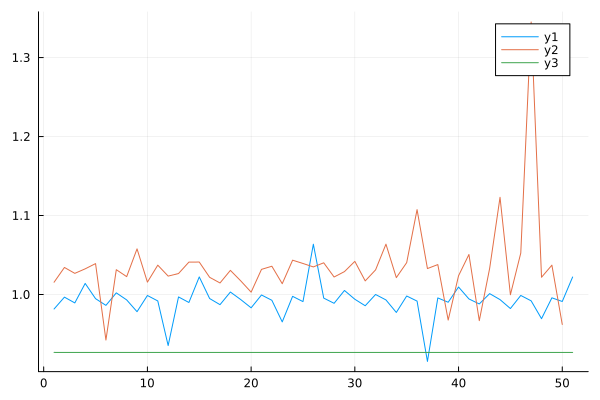

In [85]:
plot((grad./FD_grads))
plot!((Dgrad ./ FD_Dgrads)[2:end])
plot!(grad_phi ./ FD_phigrads)#,ylim=(0.95,1.05))
# FD_grads, 
# grad[end]

0.6048066880648406

In [15]:
FD_phigrad, grad_phi

(-3.0234258462047414, -3.0413874632803406)

In [17]:
FD_grad, grad[26]

(0.010773033081168393, 0.010770361064885407)

In [20]:
FD_Dgrad, Dgrad[26]

(0.6048066880648406, 0.592927707518696)